# Tensorflow Tutorial - Simple Trading Strategy based on overnight returns

In [42]:
# !pip install tensorflow
# !pip install pyfolio

In [2]:
import math
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import pyfolio as pf

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [3]:
import yfinance as yf
bn = yf.download('^NSEBANK', '2008-01-01', '2022-3-29', auto_adjust=False)
# bn1 = bn.reset_index(drop=False)
bn.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-22,35975.601562,36468.800781,35384.750000,36348.550781,36348.550781,202900
2022-03-23,36627.699219,36827.601562,36064.750000,36147.351562,36147.351562,197900
2022-03-24,35633.699219,35957.699219,35421.699219,35527.101562,35527.101562,205200
2022-03-25,35700.398438,35717.398438,35203.851562,35410.101562,35410.101562,157000
2022-03-28,35488.699219,35770.800781,35016.300781,35710.500000,35710.500000,197000


In [4]:
# import yfinance as yf
# bn = yf.download('^NSEBANK', '2008-01-01', '2022-1-25', auto_adjust=False)
bn1 = bn.reset_index(drop=False)
bn1.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3210,2022-03-22,35975.601562,36468.800781,35384.750000,36348.550781,36348.550781,202900
3211,2022-03-23,36627.699219,36827.601562,36064.750000,36147.351562,36147.351562,197900
3212,2022-03-24,35633.699219,35957.699219,35421.699219,35527.101562,35527.101562,205200
3213,2022-03-25,35700.398438,35717.398438,35203.851562,35410.101562,35410.101562,157000
3214,2022-03-28,35488.699219,35770.800781,35016.300781,35710.500000,35710.500000,197000


In [5]:
bn1=bn.reset_index()['Close']

In [6]:
bn1.shape

(3215,)

In [7]:
bn1[:]

0        9905.250000
1       10250.849609
2       10100.700195
3       10233.200195
4       10391.099609
            ...     
3210    36348.550781
3211    36147.351562
3212    35527.101562
3213    35410.101562
3214    35710.500000
Name: Close, Length: 3215, dtype: float64

In [8]:
bn1

0        9905.250000
1       10250.849609
2       10100.700195
3       10233.200195
4       10391.099609
            ...     
3210    36348.550781
3211    36147.351562
3212    35527.101562
3213    35410.101562
3214    35710.500000
Name: Close, Length: 3215, dtype: float64

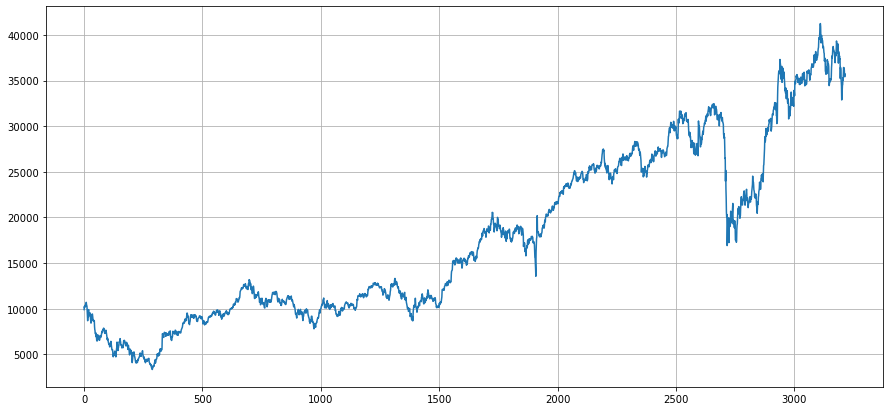

In [9]:
import matplotlib.pyplot as plt
bn1.plot(figsize=(15, 7), grid=True)
plt.show()

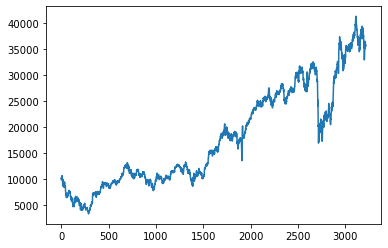

In [10]:
# other way

plt.plot(bn1)

### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
bn1=scaler.fit_transform(np.array(bn1).reshape(-1,1))  ## This convert the bn1 in array
bn1

array([[0.17323991],
       [0.18235897],
       [0.17839709],
       ...,
       [0.84930316],
       [0.84621598],
       [0.85414235]])

In [12]:
## Spliting dataset into train and test split
training_size=int(len(bn1)*0.65)
test_size=len(bn1)-training_size
train_data,test_data=bn1[0:training_size,:],bn1[training_size:len(bn1),:1]

In [13]:
training_size,test_size

(2089, 1126)

In [14]:
len(train_data),len(test_data)

(2089, 1126)

In [15]:
train_data, test_data

(array([[0.17323991],
        [0.18235897],
        [0.17839709],
        ...,
        [0.54447259],
        [0.55350594],
        [0.55238185]]),
 array([[0.555097  ],
        [0.54854926],
        [0.55329217],
        ...,
        [0.84930316],
        [0.84621598],
        [0.85414235]]))

In [16]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
        dataX, dataY=[],[]
        for i in range(len(dataset)-time_step-1):
            a=dataset[i:(i+time_step),0]    ###[=0, 0,1,2,3-------99    200]
            dataX.append(a)
            dataY.append(dataset[i+time_step,0])
        return numpy.array(dataX), numpy.array(dataY)

In [17]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step=100
X_train, Y_train=create_dataset(train_data, time_step)
X_test, Ytest=create_dataset(test_data,time_step)

In [18]:
print(X_train)

[[0.17323991 0.18235897 0.17839709 ... 0.0904453  0.08586729 0.09080018]
 [0.18235897 0.17839709 0.18189327 ... 0.08586729 0.09080018 0.08541344]
 [0.17839709 0.18189327 0.18605963 ... 0.09080018 0.08541344 0.08561398]
 ...
 [0.46748957 0.47193564 0.47630915 ... 0.55669599 0.5514069  0.54711121]
 [0.47193564 0.47630915 0.48236607 ... 0.5514069  0.54711121 0.54347125]
 [0.47630915 0.48236607 0.47770762 ... 0.54711121 0.54347125 0.54447259]]


In [19]:
print(X_train.shape), print(Y_train.shape)

(1988, 100)
(1988,)


(None, None)

In [20]:
print(X_test.shape), print(Ytest.shape)

(1025, 100)
(1025,)


(None, None)

In [21]:
# reshape input to be [sample, time steps, features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [22]:
# !pip install tensorflow

In [23]:
import tensorflow as tf

In [24]:
tf.__version__

'2.9.0-dev20220315'

In [25]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [27]:
X_train[:100]

array([[[0.17323991],
        [0.18235897],
        [0.17839709],
        ...,
        [0.0904453 ],
        [0.08586729],
        [0.09080018]],

       [[0.18235897],
        [0.17839709],
        [0.18189327],
        ...,
        [0.08586729],
        [0.09080018],
        [0.08541344]],

       [[0.17839709],
        [0.18189327],
        [0.18605963],
        ...,
        [0.09080018],
        [0.08541344],
        [0.08561398]],

       ...,

       [[0.0904453 ],
        [0.08586729],
        [0.09080018],
        ...,
        [0.05907078],
        [0.05502974],
        [0.05651792]],

       [[0.08586729],
        [0.09080018],
        [0.08541344],
        ...,
        [0.05502974],
        [0.05651792],
        [0.04865219]],

       [[0.09080018],
        [0.08541344],
        [0.08561398],
        ...,
        [0.05651792],
        [0.04865219],
        [0.05130797]]])

In [28]:
model.fit(X_train,Y_train,validation_data=(X_test,Ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
32/32 [==============================] - 9s 167ms/step - loss: 0.0090 - val_loss: 0.0169
Epoch 2/100
32/32 [==============================] - 4s 123ms/step - loss: 4.9743e-04 - val_loss: 0.0017
Epoch 3/100
32/32 [==============================] - 4s 123ms/step - loss: 2.6959e-04 - val_loss: 0.0017
Epoch 4/100
32/32 [==============================] - 4s 119ms/step - loss: 2.5703e-04 - val_loss: 0.0016
Epoch 5/100
32/32 [==============================] - 4s 124ms/step - loss: 2.4627e-04 - val_loss: 0.0018
Epoch 6/100
32/32 [==============================] - 4s 122ms/step - loss: 2.5056e-04 - val_loss: 0.0016
Epoch 7/100
32/32 [==============================] - 4s 129ms/step - loss: 2.4111e-04 - val_loss: 0.0015
Epoch 8/100
32/32 [==============================] - 4s 120ms/step - loss: 2.4554e-04 - val_loss: 0.0015
Epoch 9/100
32/32 [==============================] - 4s 119ms/step - loss: 2.2781e-04 - val_loss: 0.0015
Epoch 10/100
32/32 [==============================] - 4s 12

32/32 [==============================] - 4s 120ms/step - loss: 6.5421e-05 - val_loss: 7.3253e-04
Epoch 77/100
32/32 [==============================] - 4s 119ms/step - loss: 6.5687e-05 - val_loss: 2.7057e-04
Epoch 78/100
32/32 [==============================] - 4s 122ms/step - loss: 6.8796e-05 - val_loss: 2.6412e-04
Epoch 79/100
32/32 [==============================] - 4s 122ms/step - loss: 6.9675e-05 - val_loss: 2.6828e-04
Epoch 80/100
32/32 [==============================] - 4s 117ms/step - loss: 6.6312e-05 - val_loss: 6.0315e-04
Epoch 81/100
32/32 [==============================] - 4s 118ms/step - loss: 6.1807e-05 - val_loss: 3.0268e-04
Epoch 82/100
32/32 [==============================] - 4s 119ms/step - loss: 5.9776e-05 - val_loss: 2.9163e-04
Epoch 83/100
32/32 [==============================] - 4s 117ms/step - loss: 5.9783e-05 - val_loss: 2.5233e-04
Epoch 84/100
32/32 [==============================] - 4s 117ms/step - loss: 6.5389e-05 - val_loss: 3.3802e-04
Epoch 85/100
32/32 [===

In [30]:
### Letsdo the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


33/33 [==============================] - 1s 23ms/step


In [31]:
### Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [32]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Ytest,test_predict))

28893.80007029278

In [33]:
# Compute the percentage change

# Previous day close to today's open
bn['overnight_returns'] = (
    bn['Open']-bn['Close'].shift(1))/bn['Close'].shift(1)

# Open to Close
bn['intraday_returns'] = (bn['Close']-bn['Open'])/bn['Open']

bn.tail()

,Open,High,Low,Close,Adj Close,Volume,overnight_returns,intraday_returns
Date,,,,,,,,
2022-03-22,35975.601562,36468.800781,35384.750000,36348.550781,36348.550781,202900,-0.001191,0.010367
2022-03-23,36627.699219,36827.601562,36064.750000,36147.351562,36147.351562,197900,0.007680,-0.013114
2022-03-24,35633.699219,35957.699219,35421.699219,35527.101562,35527.101562,205200,-0.014210,-0.002991
2022-03-25,35700.398438,35717.398438,35203.851562,35410.101562,35410.101562,157000,0.004878,-0.008131
2022-03-28,35488.699219,35770.800781,35016.300781,35710.500000,35710.500000,197000,0.002220,0.006250


In [34]:
import numpy as np

In [35]:
# Define your conditions on which you want to trade

cond_1 = bn.overnight_returns < -0.01
cond_2 = bn.overnight_returns > -0.02

# Store it in the signal columns of dataframe data

bn['signal'] = np.where(cond_1 & cond_2, 1, 0)

bn.tail()

,Open,High,Low,Close,Adj Close,Volume,overnight_returns,intraday_returns,signal
Date,,,,,,,,,
2022-03-22,35975.601562,36468.800781,35384.750000,36348.550781,36348.550781,202900,-0.001191,0.010367,0
2022-03-23,36627.699219,36827.601562,36064.750000,36147.351562,36147.351562,197900,0.007680,-0.013114,0
2022-03-24,35633.699219,35957.699219,35421.699219,35527.101562,35527.101562,205200,-0.014210,-0.002991,1
2022-03-25,35700.398438,35717.398438,35203.851562,35410.101562,35410.101562,157000,0.004878,-0.008131,0
2022-03-28,35488.699219,35770.800781,35016.300781,35710.500000,35710.500000,197000,0.002220,0.006250,0


In [36]:
bn.loc[bn.signal==1].head()

,Open,High,Low,Close,Adj Close,Volume,overnight_returns,intraday_returns,signal
Date,,,,,,,,,
2008-03-07,7474.299805,7474.299805,7064.500000,7268.149902,7268.149902,0,-0.015030,-0.027581,1
2008-03-10,7163.500000,7375.200195,6945.500000,7272.500000,7272.500000,0,-0.014398,0.015216,1
2008-03-11,7186.100098,7481.750000,7124.600098,7356.399902,7356.399902,0,-0.011880,0.023699,1
2008-03-13,7226.799805,7226.799805,6840.649902,6914.649902,6914.649902,0,-0.015630,-0.043193,1
2008-05-22,7283.600098,7288.649902,7132.299805,7147.299805,7147.299805,0,-0.012293,-0.018713,1


In [37]:
bn.loc[bn.signal==1].tail()

,Open,High,Low,Close,Adj Close,Volume,overnight_returns,intraday_returns,signal
Date,,,,,,,,,
2022-02-11,38567.648438,38790.250000,38396.398438,38517.250000,38517.250000,155000,-0.011363,-0.001307,1
2022-02-28,35938.949219,36270.250000,35611.898438,36205.300781,36205.300781,238300,-0.013500,0.007411,1
2022-03-04,34526.101562,35097.750000,34094.101562,34407.800781,34407.800781,194500,-0.011968,-0.003426,1
2022-03-08,32531.900391,33263.550781,32155.349609,33158.101562,33158.101562,276800,-0.010324,0.019249,1
2022-03-24,35633.699219,35957.699219,35421.699219,35527.101562,35527.101562,205200,-0.014210,-0.002991,1


In [38]:
# Compute the strategy returns
strategy_returns = bn.signal * bn.intraday_returns

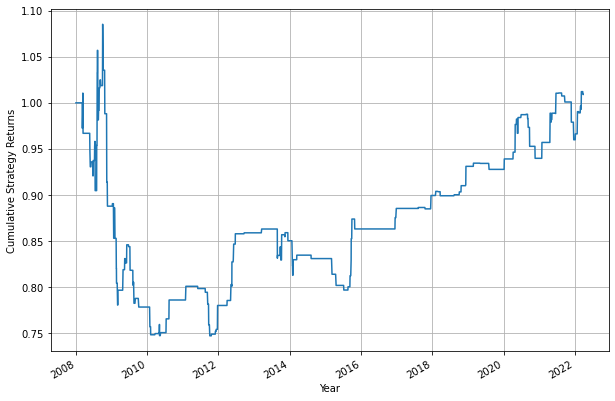

In [39]:
# Plot the cumulative strategy returns
(strategy_returns+1).cumprod().plot(figsize=(10, 7), grid=True)
plt.xlabel('Year')
plt.ylabel('Cumulative Strategy Returns')
plt.show()

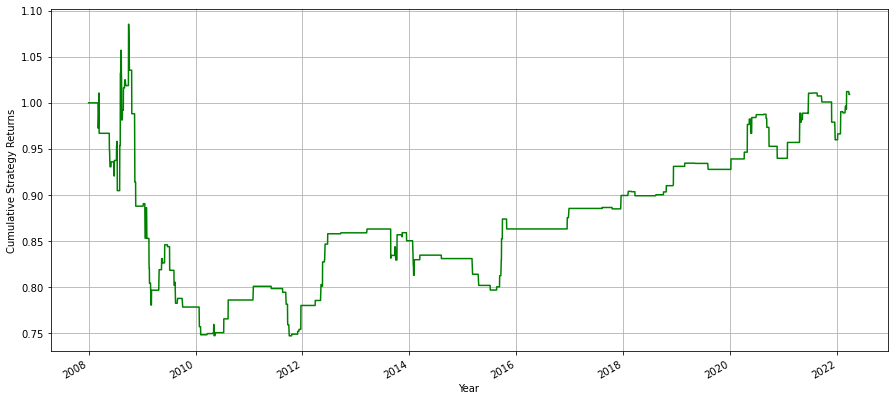

In [40]:
(strategy_returns+1).cumprod().plot(figsize=(15, 7), grid=True, color='g')
plt.xlabel('Year')
plt.ylabel('Cumulative Strategy Returns')
plt.show()

# Detailed Performance Analysis

### pf.create_full_tear_sheet(strategy_returns)

Start date,2008-01-01
End date,2022-03-28
Total months,153
,Backtest
Annual return,0.1%
Cumulative returns,0.9%
Annual volatility,7.2%
Sharpe ratio,0.05
Calmar ratio,0.00
Stability,0.33
Max drawdown,-31.1%


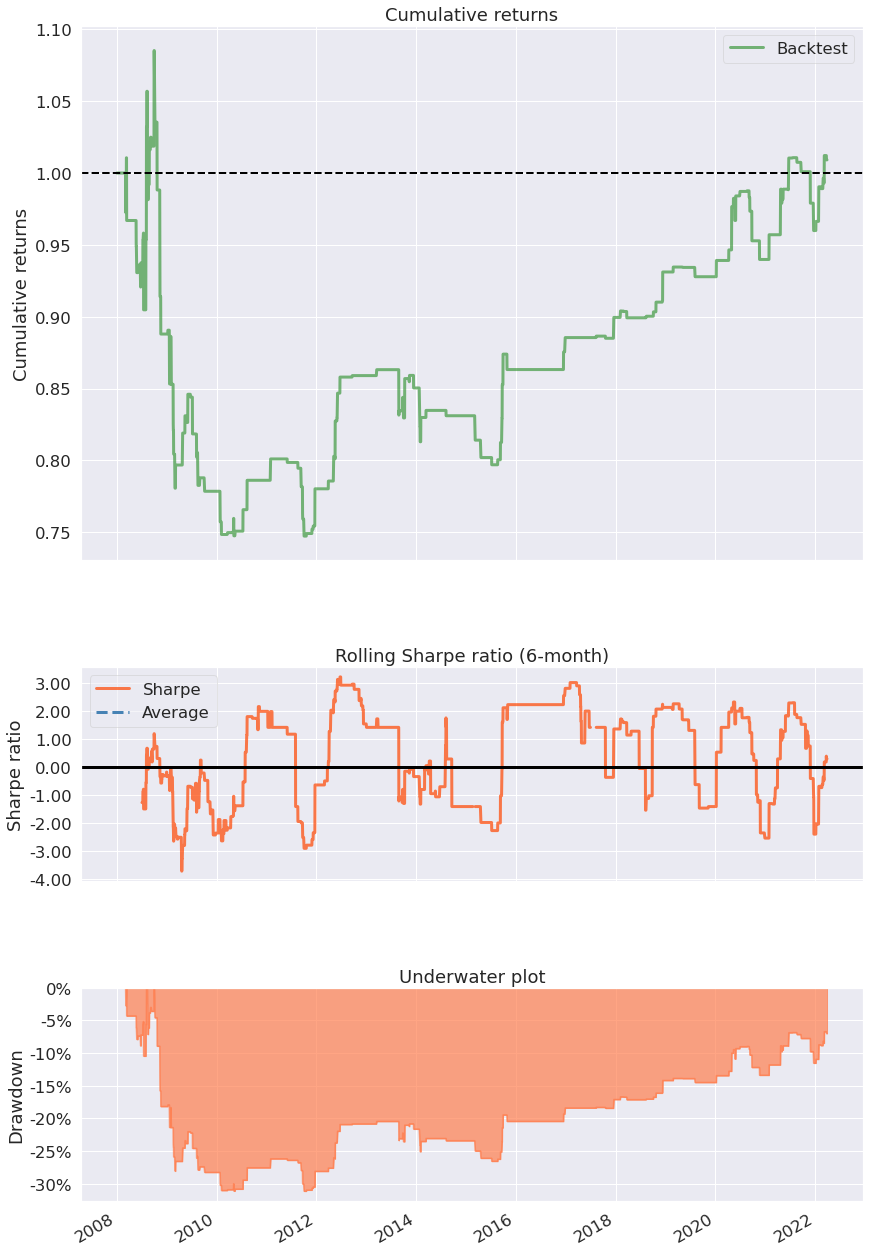

In [41]:
pf.create_simple_tear_sheet(strategy_returns)